<h1>Seed classification </h1>

**ID: AI-0007<br>
Submission date: 16-1-2018**
<br><br>

# INTRODUCTION

The objective of this assignment is to classify different type of seeds.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import *

This function print 4 images from each classes.

In [39]:
import matplotlib.pyplot as plt
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1
    plt.show()

First take 3 list for train set, label of the train set and fot test set.Also map the output labels from 0-11

In [40]:
x_train = []
x_test = []
y_train = []

df_test = pd.read_csv('sample_submission.csv')

label_map = {   "Black-grass"               :0,
                "Charlock"                  :1,
                "Cleavers"                  :2,
                "Common Chickweed"          :3,
                "Common wheat"              :4,
                "Fat Hen"                   :5,
                "Loose Silky-bent"          :6,
                "Maize"                     :7,
                "Scentless Mayweed"         :8,
                "Shepherds Purse"           :9,
                "Small-flowered Cranesbill" :10,
                "Sugar beet"                :11}

In [41]:
from glob import glob
images_per_class = {}
for class_folder_name in os.listdir("train/"):
    class_folder_path = os.path.join("train/", class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

Let's see, how many images each class have. Also visulaize some of them.

In [42]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Black-grass -> 263
Charlock -> 390
Cleavers -> 287
Common Chickweed -> 611
Common wheat -> 221
Fat Hen -> 475
Loose Silky-bent -> 654
Maize -> 221
Scentless Mayweed -> 516
Shepherds Purse -> 231
Small-flowered Cranesbill -> 496
Sugar beet -> 385


Black-grass


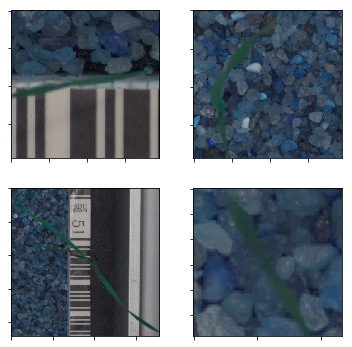

Charlock


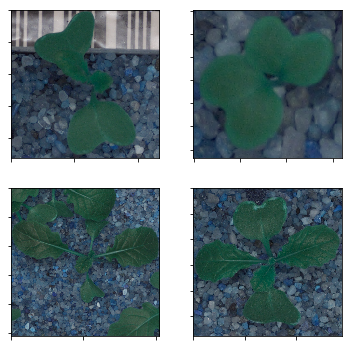

Cleavers


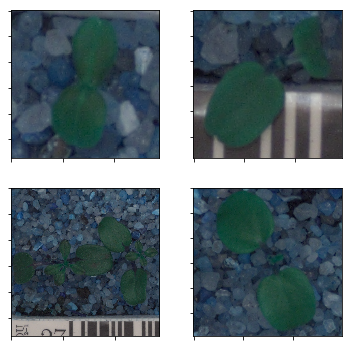

Common Chickweed


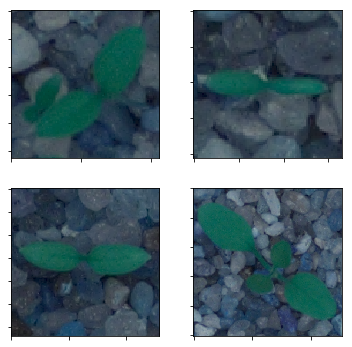

Common wheat


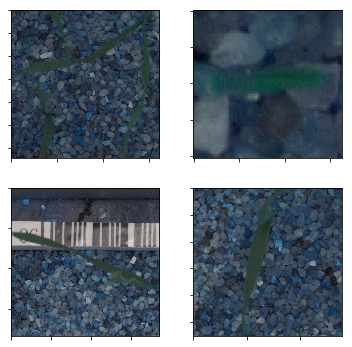

Fat Hen


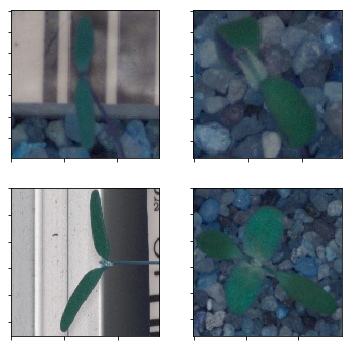

Loose Silky-bent


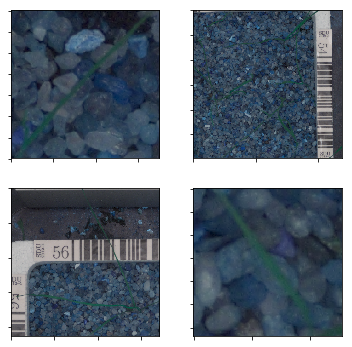

Maize


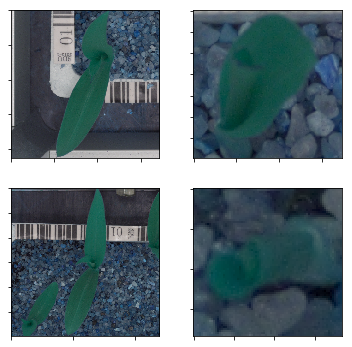

Scentless Mayweed


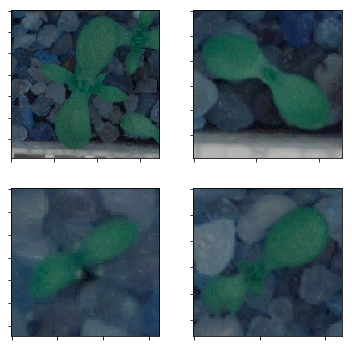

Shepherds Purse


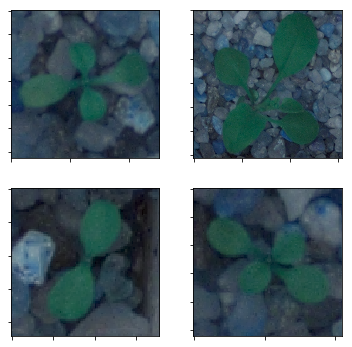

Small-flowered Cranesbill


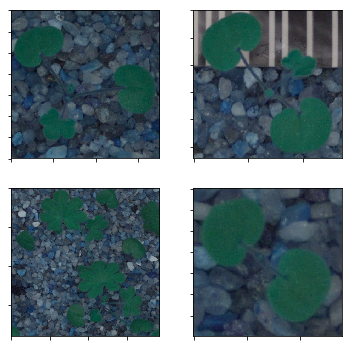

Sugar beet


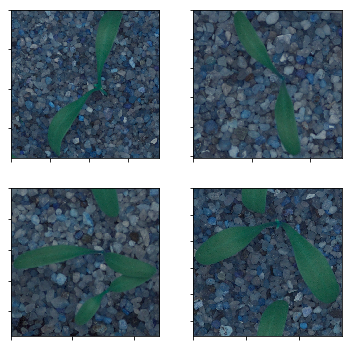

In [43]:
for label in  label_map:
    print(label)
    plot_for_class(label)

In [44]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

At first , i think segmented images may give better accuracy.so i segment all the images.Here is some overview of segmented images.

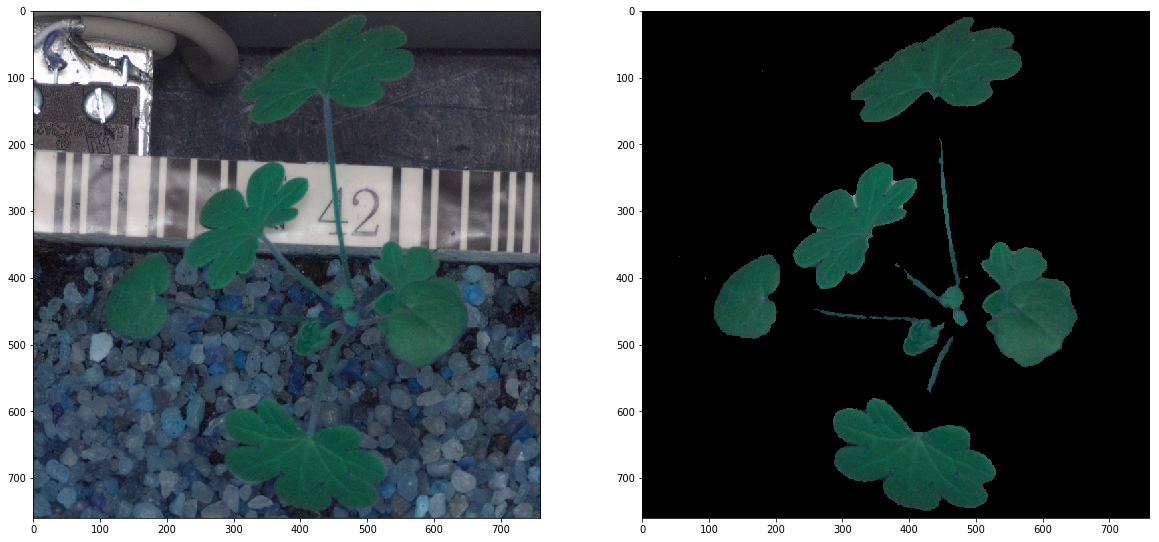

In [45]:
image = images_per_class["Small-flowered Cranesbill"][97]

image_segmented = segment_plant(image)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_segmented)
plt.show()

In [46]:
dim = 139

Let's Preparing training data from given training images.

In [47]:

dirs = os.listdir("train/")
for k in tqdm(range(len(dirs))):    # Directory
    files = os.listdir("train/{}".format(dirs[k]))
    for f in range(len(files)):     # Files
        img = cv2.imread('train/{}/{}'.format(dirs[k], files[f]))
        targets = np.zeros(12)
        targets[label_map[dirs[k]]] = 1 
        x_train.append(cv2.resize(img, (dim, dim)))
        y_train.append(targets)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:40<00:00,  3.35s/it]


In [48]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

(4750, 139, 139, 3)
(4750, 12)


Let's split the data into train and validation set to observe how model is working.

In [49]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(x_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = x_train[train_index], x_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 3990 for training and 760 for validation


although Dropout prevent model from overfitting, but as some extra precaution i use data augmentation to prevent overfitting

In [50]:
datagen = ImageDataGenerator( horizontal_flip=True, 
                              vertical_flip=True)
                                      
weights = os.path.join('', 'weightsinception3 .h5')

In [51]:
epochs = 20
learning_rate = 0.0001
batch_size = 32

In [52]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

Now all my necessary materials are prepaired, Let's create a model for predict the images. I use **InceptionV3** pre-trained model to predict the images.

In [53]:
base_model = InceptionV3(input_shape=(dim, dim, 3), include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [54]:
model.summary()   
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 69, 69, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 69, 69, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 69, 69, 32)   0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 15, 15, 64)   192         conv2d_208[0][0]                 
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 15, 15, 64)   192         conv2d_210[0][0]                 
__________________________________________________________________________________________________
batch_normalization_213 (BatchN (None, 15, 15, 96)   288         conv2d_213[0][0]                 
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 15, 15, 64)   192         conv2d_214[0][0]                 
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 15, 15, 64)   0           batch_normalization_208[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 7, 7, 192)    576         conv2d_229[0][0]                 
__________________________________________________________________________________________________
batch_normalization_232 (BatchN (None, 7, 7, 192)    576         conv2d_232[0][0]                 
__________________________________________________________________________________________________
batch_normalization_237 (BatchN (None, 7, 7, 192)    576         conv2d_237[0][0]                 
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 7, 7, 192)    576         conv2d_238[0][0]                 
__________________________________________________________________________________________________
activation_229 (Activation)     (None, 7, 7, 192)    0           batch_normalization_229[0][0]    
__________

batch_normalization_262 (BatchN (None, 7, 7, 192)    576         conv2d_262[0][0]                 
__________________________________________________________________________________________________
activation_262 (Activation)     (None, 7, 7, 192)    0           batch_normalization_262[0][0]    
__________________________________________________________________________________________________
conv2d_259 (Conv2D)             (None, 7, 7, 192)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 7, 7, 192)    258048      activation_262[0][0]             
__________________________________________________________________________________________________
batch_normalization_259 (BatchN (None, 7, 7, 192)    576         conv2d_259[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_6[0][0]              
                                                                 activation_282[0][0]             
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          524544      global_average_pooling2d_3[0][0] 
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256)          0           dense_5[0][0]                    
__________________________________________________________________________________________________
dense_6 (D

Let's train my model. as i saved my weight in toa .h5 file, and if that file exist in my directory, than no need to feed the model again.

In [55]:
# ------ TRAINING ------
if os.path.isfile(weights):
    print("weight already exist")
else:
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    validation_steps=len(x_valid)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs, 
                    verbose=1)

weight already exist


As my full model is now trained and fitted, now prepair my test data to prdict.

In [56]:
# ------ TESTING ------
for f, species in tqdm(df_test.values, miniters=100):
    img = cv2.imread('test/{}'.format(f))
    x_test.append(cv2.resize(img, (dim, dim)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

if os.path.isfile(weights):
    model.load_weights(weights)

100%|███████████████████████████████████████████████████████████████████████████████| 794/794 [00:03<00:00, 217.38it/s]


(794, 139, 139, 3)


Let's predict the images.

In [57]:
p_test = model.predict(x_test, verbose=1)

794/794 [==============================] - ETA: 57 - ETA: 29 - ETA: 19 - ETA: 14 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 7ms/step


Convert the pretiction to its actual class and create the result csv.

In [58]:
preds = []
for i in range(len(p_test)):
    pos = np.argmax(p_test[i])
    preds.append(list(label_map.keys())[list(label_map.values()).index(pos)])
    
df_test['species'] = preds
df_test.to_csv('seed_submission.csv', index=False)

# CONCLUSION

The idea of this project was to get introduced to pre-trained CNN models and how it can be implemented. With even more fine-tuning of the data better resul can be achieved.

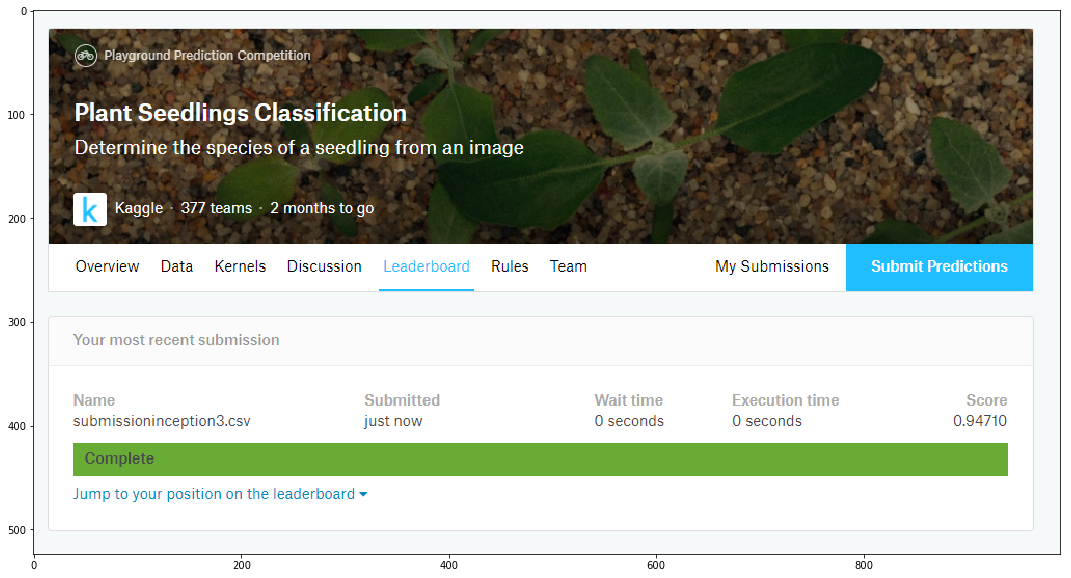

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.gcf()
fig.set_size_inches(20, 10)
img=mpimg.imread('result_seed.png')
imgplot = plt.imshow(img)
plt.show()